# Homework 9 - Part 2 Notebook

In this homework notebook, we will create and train our own SkipGram embedding, by using the short synopsis of the Lion King movie explained to kids in the text.text file.

Get familiar with the code and write a small report (2 or 3 pages, idk), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 8th, 11.59pm!**

**Sathvik 1004286**

### Imports needed

Note, we strongly advise to use a CUDA/GPU machine for this notebook.

Technically, this can be done on CPU only, but it will be very slow!

If you decide to use it on CPU, you might also have to change some of the .cuda() methods used on torch tensors and models in this notebook!

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()

### Testing for CUDA

We advise running on GPU and setting up CUDA on your machine as it might drastically speed up the running time for this notebook!

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


### Step 1. Produce some data based on a given text for training our SkipGram model    

The functions below will be used to produce our dataset for training the SkipGram model.

The dataset text consists of a short description of the story behing the movie The Lion King, explained in simple terms to kids.

In [3]:
def text_to_train(text, context_window):
    """
    This function receives the text as a list of words, in lowercase format.
    It then returns data, a list of all the possible (x,y) pairs with
    - x being the middle word of the sentence of length 2*context_window+1,
    - y being a list of 2k words, containing the k preceding words and the k
    posterior words.
    """
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        target = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        input_word = text[i]
        data.append((input_word, target))
        
    return data

In [4]:
def create_text():
    """
    This function loads the string of text from the text.txt file,
    and produces a list of words in string format, as variable text.
    """
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [5]:
text = create_text()
print(text)

['the', 'lion', 'king', 'is', 'an', 'animated', 'movie', 'made', 'by', 'walt', 'disney', 'in', '1994', 'it', 'was', 'the', 'most', 'successful', 'animated', 'movie', 'of', 'the', '1990s', 'the', 'movie', 'is', 'about', 'a', 'young', 'lion', 'prince', 'who', 'learns', 'about', 'his', 'role', 'as', 'prince', 'and', 'in', 'the', 'circle', 'of', 'life', 'it', 'is', 'dedicated', 'to', 'frank', 'wells', 'who', 'was', 'the', 'president', 'of', 'the', 'walt', 'disney', 'company', 'and', 'died', 'shortly', 'before', 'the', 'movie', 'was', 'released', 'into', 'theaters', 'on', 'june', '15', '1994', 'it', 'was', 'the', 'first', 'fulllength', 'disney', 'movie', 'to', 'feature', 'no', 'human', 'characters', 'since', 'bambi', 'much', 'of', 'the', 'voice', 'acting', 'work', 'was', 'done', 'by', 'wellknown', 'actors', 'including', 'james', 'earl', 'jones', 'jeremy', 'irons', 'matthew', 'broderick', 'whoopi', 'goldberg', 'rowan', 'atkinson', 'jonathan', 'taylor', 'thomas', 'and', 'nathan', 'lane', 'the

In [6]:
def generate_data(text, context_window):
    """
    This function receives the text and context window size.
    It produces four outputs:
    - vocab, a set containing the words found in text.txt,
    without any doublons,
    - word2index, a dictionary to convert words to their integer index,
    - word2index, a dictionary to convert integer index to their respective words,
    - data, containing our (x,y) pairs for training.
    """
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [7]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [8]:
print("The dataset contains", len(vocab), "different words.")

The dataset contains 389 different words.


In [9]:
print("The dadatset contains the following words:")
print(vocab)

The dadatset contains the following words:
{'irons', 'be', 'animation', 'thinks', 'starts', 'on', 'people', 'jones', 'fighting', 'forrest', 'up', 'very', 'meerkat', 'see', 'lifts', 'falls', 'they', 'into', 'during', 'speaks', 'lion', 'their', 'long', 'desert', 'opened', 'below', 'ed', 'june', 'compared', 'must', 'where', 'alone', 'rain', 'both', 'until', 'attack', 'roars', 'goldberg', 'everything', 'want', 'collapses', 'finds', 'big', 'music', 'york', 'shows', 'to', 'fight', '2', 'banzai', 'sees', 'success', 'explains', 'john', 'at', 'released', 'have', 'field', 'them', 'songs', 'awardwinning', 'chased', 'city', 'rescued', 'hakuna', 'high', 'fights', 'picks', 'human', 'there', 'planned', 'waiting', 'shrek', 'blames', 'saves', 'brother', 'lies', 'lightning', 'from', 'working', 'two', 'but', 'with', 'celebrate', 'won', 'who', 'rafiki', 'valley', 'computer', 'wonderful', 'circle', 'away', 'gather', 'makes', 'die', 'lane', 'then', 'tree', 'warthog', 'elephant', 'love', 'wait', 'would', 'hi

In [10]:
print(word2index)

{'irons': 0, 'be': 1, 'animation': 2, 'thinks': 3, 'starts': 4, 'on': 5, 'people': 6, 'jones': 7, 'fighting': 8, 'forrest': 9, 'up': 10, 'very': 11, 'meerkat': 12, 'see': 13, 'lifts': 14, 'falls': 15, 'they': 16, 'into': 17, 'during': 18, 'speaks': 19, 'lion': 20, 'their': 21, 'long': 22, 'desert': 23, 'opened': 24, 'below': 25, 'ed': 26, 'june': 27, 'compared': 28, 'must': 29, 'where': 30, 'alone': 31, 'rain': 32, 'both': 33, 'until': 34, 'attack': 35, 'roars': 36, 'goldberg': 37, 'everything': 38, 'want': 39, 'collapses': 40, 'finds': 41, 'big': 42, 'music': 43, 'york': 44, 'shows': 45, 'to': 46, 'fight': 47, '2': 48, 'banzai': 49, 'sees': 50, 'success': 51, 'explains': 52, 'john': 53, 'at': 54, 'released': 55, 'have': 56, 'field': 57, 'them': 58, 'songs': 59, 'awardwinning': 60, 'chased': 61, 'city': 62, 'rescued': 63, 'hakuna': 64, 'high': 65, 'fights': 66, 'picks': 67, 'human': 68, 'there': 69, 'planned': 70, 'waiting': 71, 'shrek': 72, 'blames': 73, 'saves': 74, 'brother': 75, 'l

In [11]:
print(index2word)

{0: 'irons', 1: 'be', 2: 'animation', 3: 'thinks', 4: 'starts', 5: 'on', 6: 'people', 7: 'jones', 8: 'fighting', 9: 'forrest', 10: 'up', 11: 'very', 12: 'meerkat', 13: 'see', 14: 'lifts', 15: 'falls', 16: 'they', 17: 'into', 18: 'during', 19: 'speaks', 20: 'lion', 21: 'their', 22: 'long', 23: 'desert', 24: 'opened', 25: 'below', 26: 'ed', 27: 'june', 28: 'compared', 29: 'must', 30: 'where', 31: 'alone', 32: 'rain', 33: 'both', 34: 'until', 35: 'attack', 36: 'roars', 37: 'goldberg', 38: 'everything', 39: 'want', 40: 'collapses', 41: 'finds', 42: 'big', 43: 'music', 44: 'york', 45: 'shows', 46: 'to', 47: 'fight', 48: '2', 49: 'banzai', 50: 'sees', 51: 'success', 52: 'explains', 53: 'john', 54: 'at', 55: 'released', 56: 'have', 57: 'field', 58: 'them', 59: 'songs', 60: 'awardwinning', 61: 'chased', 62: 'city', 63: 'rescued', 64: 'hakuna', 65: 'high', 66: 'fights', 67: 'picks', 68: 'human', 69: 'there', 70: 'planned', 71: 'waiting', 72: 'shrek', 73: 'blames', 74: 'saves', 75: 'brother', 76

In [12]:
print(data)

[('king', ['the', 'lion', 'is', 'an']), ('is', ['lion', 'king', 'an', 'animated']), ('an', ['king', 'is', 'animated', 'movie']), ('animated', ['is', 'an', 'movie', 'made']), ('movie', ['an', 'animated', 'made', 'by']), ('made', ['animated', 'movie', 'by', 'walt']), ('by', ['movie', 'made', 'walt', 'disney']), ('walt', ['made', 'by', 'disney', 'in']), ('disney', ['by', 'walt', 'in', '1994']), ('in', ['walt', 'disney', '1994', 'it']), ('1994', ['disney', 'in', 'it', 'was']), ('it', ['in', '1994', 'was', 'the']), ('was', ['1994', 'it', 'the', 'most']), ('the', ['it', 'was', 'most', 'successful']), ('most', ['was', 'the', 'successful', 'animated']), ('successful', ['the', 'most', 'animated', 'movie']), ('animated', ['most', 'successful', 'movie', 'of']), ('movie', ['successful', 'animated', 'of', 'the']), ('of', ['animated', 'movie', 'the', '1990s']), ('the', ['movie', 'of', '1990s', 'the']), ('1990s', ['of', 'the', 'the', 'movie']), ('the', ['the', '1990s', 'movie', 'is']), ('movie', ['19

In [13]:
def words_to_tensor(words: list, word2index: dict, dtype = torch.FloatTensor):
    """
    This fucntion converts a word or a list of words into a torch tensor,
    with appropriate format.
    It reuses the word2index dictionary.
    """
    
    tensor =  dtype([word2index[word] for word in words])
    tensor = tensor.to(device)
    
    return Variable(tensor)

### Step 2. Create a SkipGram model and train

Task #1: Write your own model for the SkipGram model below.

In [18]:
class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        self.context_size = context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view(1, -1) #reshape to 1-d vector
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        log_probs = torch.cat([out]*self.context_size*2) # shared weights
        log_probs = log_probs.view(2*self.context_size, -1)
        return log_probs

In [19]:
# Create model and pass to CUDA if available.
model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
model = model.to(device)
model.train()

SkipGram(
  (embeddings): Embedding(389, 20)
  (linear1): Linear(in_features=20, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=389, bias=True)
)

In [25]:
# Define training parameters
learning_rate = 0.001
epochs = 50
torch.manual_seed(28)
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

Task #2: Write your own training function for the SkipGram model in the cell below. It should return a list of losses and accuracies for display later on, along with your trained model. You may also write a helper function for computing the accuracy of your model during training.

In [30]:
def get_prediction(context, model, word2index, index2word):
    """
    This is a helper function to get predictions from our model.
    """
    # Get into eval() mode
    model.eval()
    ids = words_to_tensor([context], word2index, dtype = torch.LongTensor)
    
    # Forward pass
    prediction = model(ids)
    # top 4 predicted words
    predicted_words = []
    idx = torch.topk(prediction, 4).indices[0]
    for index in idx:
        predicted_words.append(index2word[index.item()])
    
    return predicted_words

In [31]:
def check_accuracy(model, data, word2index, index2word):

    # Compute accuracy
    correct = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)

        for word in target:
            if word in prediction:
                correct += 1

    return correct/(4 * len(data))

In [44]:
def train(data, word2index, model, epochs, loss_func, optimizer):
    """
    This is a trainer function to train our SkipGram model.
    """
    losses = []
    accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        for context, target in data:

            # Prepare data
            ids = words_to_tensor([context], word2index, dtype = torch.LongTensor)
            target = words_to_tensor(target, word2index, dtype = torch.LongTensor)

            # Forward pass
            model.zero_grad()
            output = model(ids)
            loss = loss_func(output, target)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Loss update
            total_loss += loss.data.item()

        # Display
        if epoch % 10 == 0:
            accuracy = check_accuracy(model, data, word2index, index2word)
            print("Accuracy after epoch {} is {}".format(epoch, accuracy))
            accuracies.append(accuracy)
            losses.append(total_loss)
            
    return losses, accuracies, model

losses, accuracies, model = train(data, word2index, model, epochs, loss_func, optimizer)

Accuracy after epoch 0 is 0.21637291280148424
Accuracy after epoch 10 is 0.2242578849721707
Accuracy after epoch 20 is 0.2307513914656772
Accuracy after epoch 30 is 0.23330241187384043
Accuracy after epoch 40 is 0.23956400742115028


### 3. Visualization

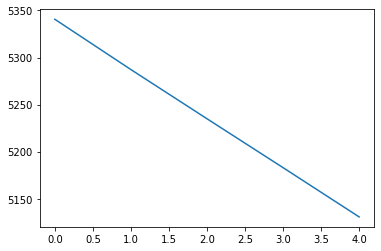

In [45]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

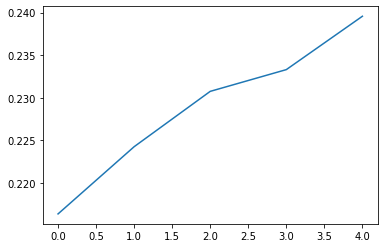

In [46]:
# Display accuracies over time
plt.figure()
plt.plot(accuracies)
plt.show()

### 4. Extract embedding and play with it? (Optional)

In [47]:
word1 = words_to_tensor(["lion"], word2index, dtype = torch.LongTensor)
word2 = words_to_tensor(["simba"], word2index, dtype = torch.LongTensor)
word3 = words_to_tensor(["daughter"], word2index, dtype = torch.LongTensor)
w1 = torch.reshape(model.embeddings(word1), (20,))
w2 = torch.reshape(model.embeddings(word2), (20,))
w3 = torch.reshape(model.embeddings(word3), (20,))
print(w1)
print(w2)
print(w3)

tensor([ 1.2516,  0.8456, -0.5436,  0.7872, -0.4899,  1.9889, -1.1532, -0.7450,
        -1.2643, -1.2773,  0.4943, -0.2201, -2.1172, -0.2884,  0.5551,  0.1713,
         0.0839, -0.5745, -0.0026, -0.6468], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor([ 1.3464,  1.1026,  0.1158,  0.0964,  1.4199,  0.9714, -0.8183,  0.3759,
        -0.2886,  0.6802,  0.4451, -1.3538,  1.1941,  0.7152, -0.7267,  0.0047,
        -0.2888,  0.9224,  1.3905,  0.1401], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor([-0.3091,  0.5915,  0.3005, -0.2372, -0.7165,  0.8173, -0.2180,  0.4993,
        -0.1521,  0.4898, -0.5632,  0.8190,  0.9338, -0.2438, -0.3635, -0.8517,
        -1.3055, -1.1574,  0.0361,  1.8492], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)


In [48]:
# lion and simba have a somewhat close semantic meaning (positive value)
print(torch.dot(w1, w2).item())
# lion and daughter do not have a close semantic meaning (neg value)
print(torch.dot(w1, w3).item())

0.7591705322265625
-2.1680543422698975


### Questions and expected answers for the report

The questions listed below are related to Part 2.

P2-QA. Copy and paste your SkipGram class code (Task #1 in this notebook).

P2-QB. Copy and paste your train function (Task #2 in the notebook), along with any helper functions you might have used (e.g. a function to compute the accuracy of your model after each iteration).
Please also copy and paste the function call with the parameters you used for the train() function.

P2-QC. Why is the SkipGram model much more difficult to train than the CBoW?
Is it problematic if it does not reach a 100% accuracy on the task it is being trained on?

P2-QD. If we were to evaluate this model by using intrinsic methods, what could be a possible approach to do so?

P2-QE. (Optional) Please submit any additional code you might that will demonstrate the performance/problems of the word embedding you have trained!

P2-QA:

    class SkipGram(nn.Module):
    """
        Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        self.context_size = context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view(1, -1) #reshape to 1-d vector
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        log_probs = torch.cat([out]*self.context_size*2) # shared weights
        log_probs = log_probs.view(2*self.context_size, -1)
        return log_probs



P2-QB:
    
    def get_prediction(context, model, word2index, index2word):
    """
    This is a helper function to get predictions from our model.
    """
    # Get into eval() mode
    model.eval()
    ids = words_to_tensor([context], word2index, dtype = torch.LongTensor)
    
    # Forward pass
    prediction = model(ids)
    # top 4 predicted words
    predicted_words = []
    idx = torch.topk(prediction, 4).indices[0]
    for index in idx:
        predicted_words.append(index2word[index.item()])
    
    return predicted_words
    
    
    
    def check_accuracy(model, data, word2index, index2word):

    # Compute accuracy
    correct = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)

        for word in target:
            if word in prediction:
                correct += 1

    return correct/(4 * len(data))
    
    
    def train(data, word2index, model, epochs, loss_func, optimizer):
    """
    This is a trainer function to train our SkipGram model.
    """
    losses = []
    accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        for context, target in data:

            # Prepare data
            ids = words_to_tensor([context], word2index, dtype = torch.LongTensor)
            target = words_to_tensor(target, word2index, dtype = torch.LongTensor)

            # Forward pass
            model.zero_grad()
            output = model(ids)
            loss = loss_func(output, target)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Loss update
            total_loss += loss.data.item()

        # Display
        if epoch % 10 == 0:
            accuracy = check_accuracy(model, data, word2index, index2word)
            print("Accuracy after epoch {} is {}".format(epoch, accuracy))
            accuracies.append(accuracy)
            losses.append(total_loss)
            
    return losses, accuracies, model

    losses, accuracies, model = train(data, word2index, model, epochs, loss_func, optimizer)
    
    

P2-QC:

CBoW model training predicts a single word from a fixed window size of context words but the SkipGram model tries to predict several context words from a single input word. Therefore, the SkipGram model is harder to train as it needs to get high probabilities for not just 1 right output word, but 2k output words that are contextually similar to the input word.

No, because all we want are good embedding vectors for the window of words which is obtained if the context window has high probabilities towards the target word. These words need not be in the order of the top shortlisted words in the window.

P2-QD:

Intrinsic methods would mean that we would need to rely on a human expert to judge whether the word embedding is good or not. Researchers have tried to come up with an “objective” metric to compute the similarity between two word embeddings vectors, such as the cosine similarity. A value close to 1 (resp. -1) indicate two vectors carrying a similar (resp. opposite) semantic meaning. A value 0 indicates two uncorrelated words.



In [49]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
print(cos(w1,w2)) # lion, simba
print(cos(w1,w3)) # lion, daughter

tensor(0.0460, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.1483, device='cuda:0', grad_fn=<DivBackward0>)
